In [1]:
import torch
import numpy as np
import pandas as pd
import html
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange
import sentencepiece as spm
from llama import Tokenizer
from typing import Optional, Tuple
from dataclasses import dataclass
import math

plt.style.use('ggplot')

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 1000  # what is the maximum context length for predictions?
max_iters = 100
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.01
# ------------


torch.manual_seed(1337)

df = pd.read_csv('../data/opt_intelligence_test_data.csv')

# remove NaN
df = df.dropna(subset=['PL_DATE_OF_BIRTH'])

# remove HTML characters
df['O_BODY1'] = df['O_BODY1'].apply(html.unescape)
df['O_NAME'] = df['O_NAME'].apply(html.unescape)
df['O_HEADLINE1'] = df['O_HEADLINE1'].apply(html.unescape)
df['O_DISPLAY_NAME'] = df['O_DISPLAY_NAME'].apply(html.unescape)

# shuffle dem bitches
df = df.sample(frac=1).reset_index(drop=True)

n = math.floor(df.shape[0]*.9)
train_data = df.iloc[:n, :]
val_data = df.iloc[n:, :]

tokenizer = Tokenizer(model_path='tokenizer.model')

def get_batch(split):
    strings = []
    optins = []
    data = train_data if split == 'train' else val_data
    
    # Separate positive and negative classes
    df_positive = data[data.OPTED_IN == 1]
    df_negative = data[data.OPTED_IN == 0]
    
    # Select half the batch size from each class
    half_batch = batch_size // 2
    idx_positive = torch.randperm(len(df_positive))[:half_batch]
    idx_negative = torch.randperm(len(df_negative))[:half_batch] + len(df_positive)
    
    # Combine indices and shuffle
    indices = torch.cat([idx_positive, idx_negative])
    indices = indices[torch.randperm(len(indices))]

    # Join positive and negative classes
    df_combined = pd.concat([df_positive, df_negative])

    for i in indices:
        row = df_combined.iloc[i.item()]
        string_dict = row[:-1].to_dict()  # turns row into dictionary cols=keys
        string = ', '.join(f'{k}: {v}' for k, v in string_dict.items())  # creates string from row dict
        encoded_string = torch.tensor(tokenizer.encode(string, bos=True, eos=False))  # encode string to tensor
        full_tensor = torch.full((block_size,), 0)  # create tensor as long as longest and fill with new token
        # using same token as <unk> 0
        full_tensor[:len(encoded_string)] = encoded_string  # replace beginning of full tensor with original string tensor
        encoded_string = full_tensor  # encoded string with padding
        strings.append(encoded_string)  # add tensor to list of tensors
        optin_dict = row[-1:].to_dict()  # convert optin column to dict
        optins.append(optin_dict['opted_in'.upper()])  # add optin value to list
        
    optins = torch.tensor(optins)  # turn optins list to tensor
    
    x, y = torch.stack(strings), optins
    x, y = x.to(device), y.to(device)

    return x, y






@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# from typing import Optional, Tuple
# from dataclasses import dataclass
# import math

# import torch
# from torch import nn
# import torch.nn.functional as F

# device = 'cuda' if torch.cuda.is_available() else 'cpu'


@dataclass
class ModelArgs:
    dim: int = 256
    n_layers: int = 4
    n_heads: int = 4
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    norm_eps: float = 1e-06
    max_batch_size: int = 16
    max_seq_len: int = 1024


class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        self.n_heads = args.n_heads
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)

        keys = xk
        values = xv

        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)

        return self.wo(output)




class FeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        multiple_of: int,
    ):
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim, hidden_dim=4 * args.dim, multiple_of=args.multiple_of
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]):
        h = x + self.attention.forward(self.attention_norm(x), start_pos, freqs_cis, mask)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = nn.Linear(params.dim, 1, bias=False)

        self.freqs_cis = precompute_freqs_cis(
            self.params.dim // self.params.n_heads, self.params.max_seq_len * 2
        )

    def forward(self, tokens: torch.Tensor, start_pos: int, targets=None):
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full((1, 1, seqlen, seqlen), float("-inf"), device=tokens.device)
            mask = torch.triu(mask, diagonal=start_pos + 1).type_as(h)

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.output(h[:, -1, :])  # only compute last logits
        preds = torch.sigmoid(output) # Apply sigmoid to obtain probabilities
        
        if targets is None:
            loss = None
        else:
            loss = F.binary_cross_entropy(preds.view(-1), targets.float()) # Use BCE loss, ensure targets are float

        return preds, loss


In [2]:
args = ModelArgs(vocab_size=tokenizer.n_words)
args

model = Transformer(args)
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Hyperparameters
beta1 = 0.9
beta2 = 0.95

# Set up the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(beta1, beta2))

11.602432 M parameters


In [6]:
loss_list = []
eval_num = 10
epochs = 100

from tqdm import trange

max_iters = epochs
for iter in trange(max_iters):

#     # every once in a while evaluate the loss on train and val sets
#     if iter % eval_interval == 0 or iter == max_iters - 1:
#         losses = estimate_loss()
#         print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, 0, yb)
    loss_list.append(loss.item())
#     optimizer.zero_grad()
    optimizer.zero_grad(set_to_none=True)
    loss.backward(retain_graph=True)
    optimizer.step()
    
#     if iter % eval_num == 0:
#         total = sum(loss_list)
#         loss_list = []
#         avg = total / eval_num
#         print(avg)

100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


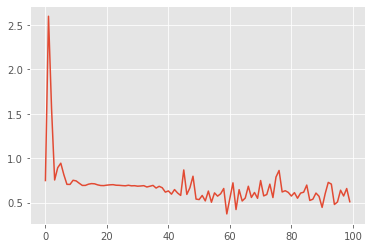

In [7]:
plt.plot(loss_list)

In [3]:
def accuracy(list1, list2):
    correct = 0
    for i in range(len(list1)):
        if list1[i] == list2[i]:
            correct += 1
    return correct / len(list1)

In [8]:
accuracy_list = []
lists1 = []
lists2 = []

EPOCHS = 100

for epoch in trange(EPOCHS):

    X, y = get_batch('test')

    output, _ = model(X, 0)


#     mean = output.mean()

    outing = []

    for outs in output:
        if outs.item() >= 0.5:
            outing.append(1)
        else:
            outing.append(0)

    list1 = outing
    lists1.append(list1)

    list2 = y.tolist()
    lists2.append(list2)
    
    accuracy_list.append(accuracy(list1, list2))
        
print(f'Accuracy = {sum(accuracy_list) / len(accuracy_list)}')

print('{:6s} {:6s} {:6s}'.format('perc', 'pred', 'true'))
for l1, l2, l3 in zip([round(num, 2) for num in output.view(-1).tolist()], list1, list2):
    print(f'{l1:6.2f} {l2:6} {l3:6}')

100%|██████████| 100/100 [00:06<00:00, 14.48it/s]

Accuracy = 0.633125
perc   pred   true  
  0.97      1      1
  0.50      1      0
  0.26      0      0
  0.23      0      1
  0.49      0      0
  0.97      1      1
  0.97      1      1
  0.51      1      1
  0.25      0      1
  0.46      0      0
  0.63      1      0
  0.98      1      1
  0.41      0      0
  0.97      1      1
  0.25      0      0
  0.50      1      0


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=300)[0].tolist()))